In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
    
    
)

Found 14303 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:
len(dataset)

447

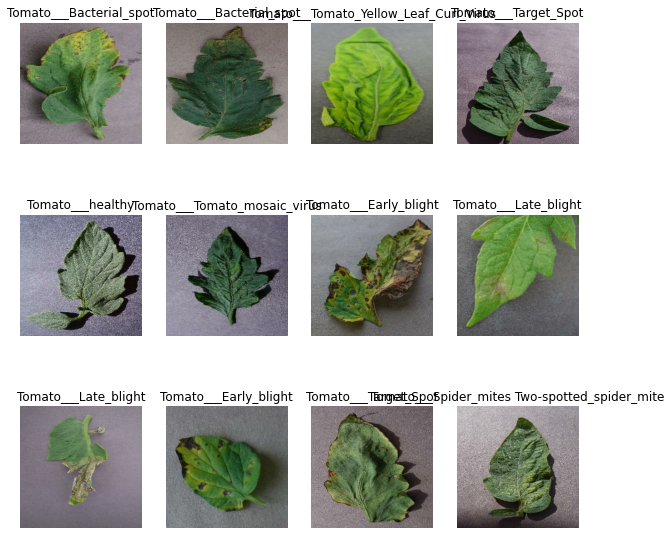

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
train_size = 0.8
len(dataset)*train_size

357.6

In [8]:
train_ds = dataset.take(146)
len(train_ds)

146

In [9]:
test_ds = dataset.skip(146)
len(test_ds)

301

In [10]:
val_size = 0.1
len(dataset)*val_size

44.7

In [11]:
val_ds = test_ds.take(18)
len(val_ds)

18

In [12]:
test_ds = test_ds.skip(18)
len(test_ds)

283

In [13]:
def get_dataset_partitions_tf(ds, train_split = 0.8,val_split = 0.1,test_split=0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split *ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

357

In [16]:
len(val_ds)

44

In [17]:
len(test_ds)

46

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
])
model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [23]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
715/715 [==============================] - 26s 26ms/step - loss: 1.7807 - accuracy: 0.3409 - val_loss: 1.3833 - val_accuracy: 0.5098
Epoch 2/100
715/715 [==============================] - 15s 20ms/step - loss: 1.0909 - accuracy: 0.6119 - val_loss: 2.0472 - val_accuracy: 0.4888
Epoch 3/100
715/715 [==============================] - 14s 20ms/step - loss: 0.7616 - accuracy: 0.7328 - val_loss: 0.9158 - val_accuracy: 0.7191
Epoch 4/100
715/715 [==============================] - 15s 21ms/step - loss: 0.5550 - accuracy: 0.8052 - val_loss: 0.5456 - val_accuracy: 0.8090
Epoch 5/100
715/715 [==============================] - 14s 20ms/step - loss: 0.4493 - accuracy: 0.8447 - val_loss: 0.4574 - val_accuracy: 0.8399
Epoch 6/100
715/715 [==============================] - 14s 20ms/step - loss: 0.3954 - accuracy: 0.8601 - val_loss: 0.4170 - val_accuracy: 0.8624
Epoch 7/100
715/715 [==============================] - 14s 20ms/step - loss: 0.3405 - accuracy: 0.8801 - val_loss: 0.5927 - val_ac

In [25]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
scores = model.evaluate(test_ds)

90/90 [==============================] - 5s 10ms/step - loss: 0.0787 - accuracy: 0.9743


In [27]:
scores

[0.07866999506950378, 0.9743055701255798]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 715}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
history.history['accuracy']

[0.34093889594078064,
 0.6118541955947876,
 0.7328437566757202,
 0.8052277565002441,
 0.844741702079773,
 0.8601276278495789,
 0.880146861076355,
 0.8872278928756714,
 0.8948334455490112,
 0.8992044925689697,
 0.9139785170555115,
 0.9159891605377197,
 0.9163388609886169,
 0.9273537993431091,
 0.9235947132110596,
 0.9361832141876221,
 0.9341725707054138,
 0.9335606098175049,
 0.9430894255638123,
 0.9403793811798096,
 0.9398548603057861,
 0.9487717747688293,
 0.9472855925559998,
 0.9473730325698853,
 0.9482472538948059,
 0.9527056813240051,
 0.9534924626350403,
 0.9507824182510376,
 0.9528805017471313,
 0.9514817595481873,
 0.9585627913475037,
 0.9548037648200989,
 0.9565521478652954,
 0.9570766687393188,
 0.9609231352806091,
 0.9605734944343567,
 0.9534924626350403,
 0.9665180444717407,
 0.9575137495994568,
 0.9613602757453918,
 0.9649444818496704,
 0.9645947813987732,
 0.9623218774795532,
 0.959699273109436,
 0.964419960975647,
 0.960136353969574,
 0.9655564427375793,
 0.96232187747955

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

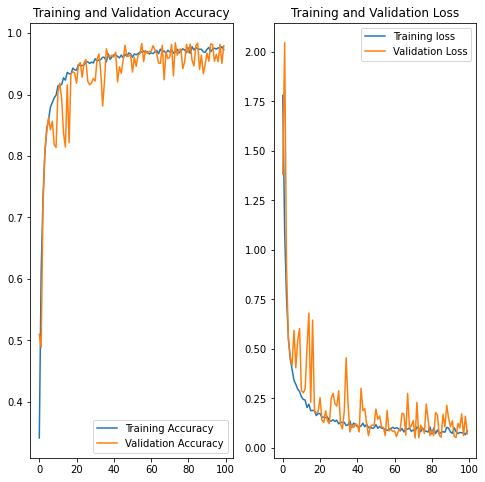

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label= 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label= 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

first_image to predict
actual label: Tomato___Early_blight
tf.Tensor(1, shape=(), dtype=int32)
predicted label: Tomato___Early_blight


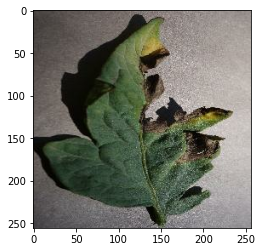

In [34]:

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first_image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    print(labels_batch[0])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [35]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

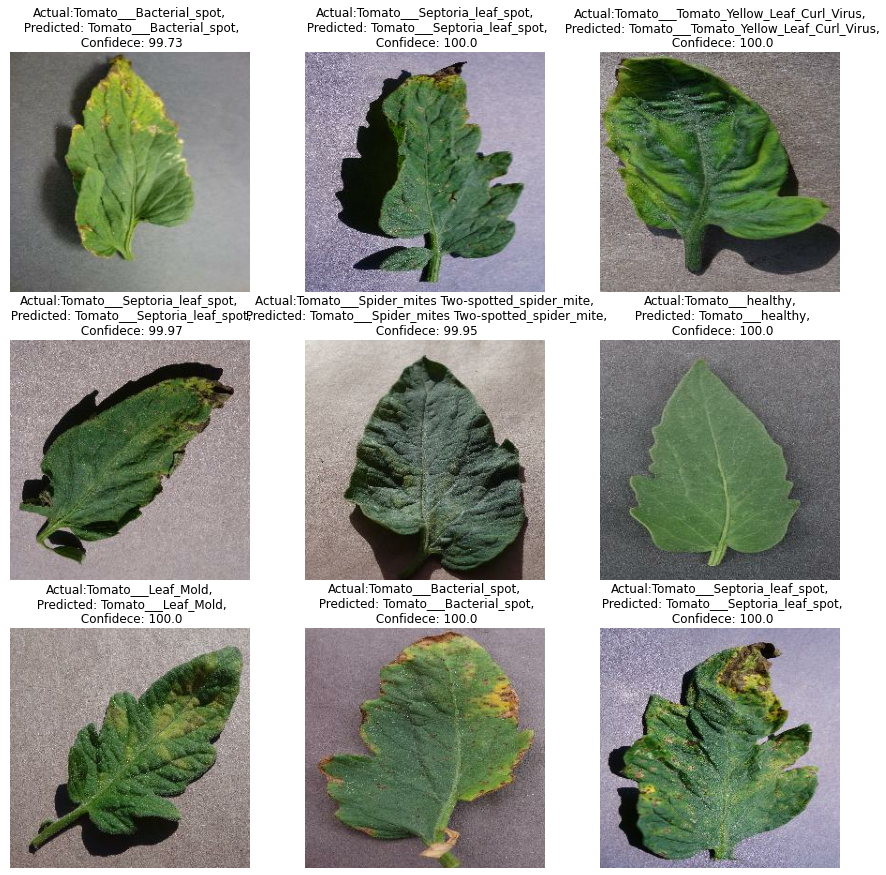

In [36]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Confidece: {confidence}")
        
        plt.axis("off")

In [3]:
# save it as a h5 file
from tensorflow.keras.models import load_model
#model.save('Models/orig_100.h5')

In [5]:
model = models.load_model('Models/orig_100.h5')

In [39]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [42]:
!pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=f46389640d6c8692b8331761e859b47b35e9007110e5689fbbc2fc181a1c60a2
  Stored in directory: c:\users\khwopa\appdata\local\pip\cache\wheels\e4\7b\98\b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [43]:
from sklearn.metrics import confusion_matrix,classification_report
import itertools
cm=confusion_matrix(predicted_labels, correct_labels)
cm

array([[221,   1,   1,   0,   1,   0,   0,   1,   0,   0],
       [  0, 108,   0,   0,   5,   0,   2,   0,   0,   0],
       [  1,   2, 212,   0,   1,   0,   1,   0,   0,   0],
       [  0,   0,   0, 106,   1,   0,   0,   0,   0,   0],
       [  0,   0,   1,   2, 156,   0,   0,   0,   0,   0],
       [  0,   0,   1,   1,   0, 149,   4,   0,   0,   0],
       [  4,   0,   0,   0,   3,   2, 136,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0, 127,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,  34,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 154]], dtype=int64)

In [44]:
target_names = []
for key in dataset.class_names:
    target_names.append(key)

In [45]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


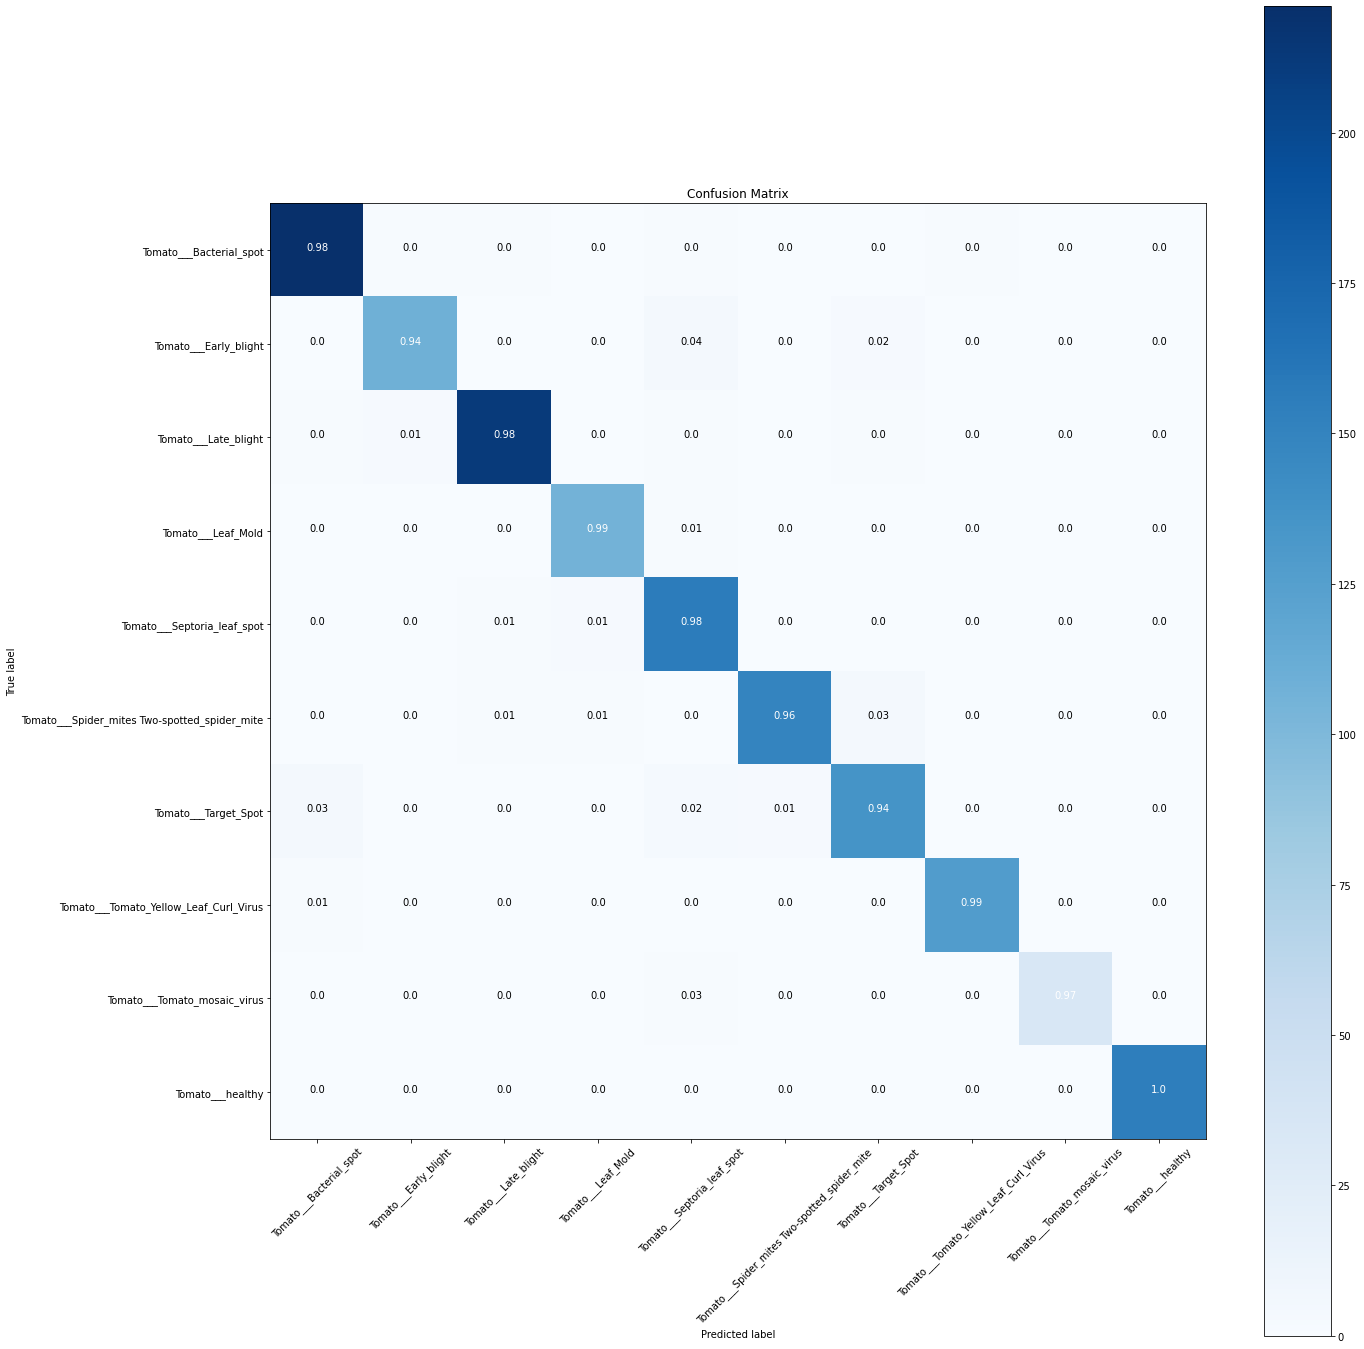

In [46]:
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
 

In [47]:
print('Classification Report')
print(classification_report(correct_labels,predicted_labels,target_names=target_names))

Classification Report
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.98      0.97      0.98       227
                        Tomato___Early_blight       0.94      0.97      0.96       111
                         Tomato___Late_blight       0.98      0.99      0.98       215
                           Tomato___Leaf_Mold       0.99      0.97      0.98       109
                  Tomato___Septoria_leaf_spot       0.98      0.93      0.95       168
Tomato___Spider_mites Two-spotted_spider_mite       0.96      0.99      0.97       151
                         Tomato___Target_Spot       0.94      0.95      0.94       143
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.99      0.99      0.99       128
                 Tomato___Tomato_mosaic_virus       0.97      1.00      0.99        34
                             Tomato___healthy       1.00      1.00      1.00       154

                   

In [48]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [49]:
correct_labels

<tf.Tensor: shape=(1440,), dtype=int32, numpy=array([5, 5, 6, ..., 6, 4, 4])>

In [50]:
predicted_labels

<tf.Tensor: shape=(1440,), dtype=int64, numpy=array([5, 5, 6, ..., 6, 4, 4], dtype=int64)>

In [51]:
predict_probability=model.predict(test_ds)

In [52]:
predict_probability

array([[1.4283246e-12, 1.7984881e-19, 1.0000000e+00, ..., 1.9026878e-17,
        5.2980663e-25, 1.7905375e-11],
       [2.9435646e-06, 3.3089280e-05, 2.5139962e-05, ..., 2.9486667e-08,
        2.4127667e-05, 4.9249147e-06],
       [9.9999917e-01, 3.6106204e-07, 1.9335024e-08, ..., 1.1375117e-10,
        0.0000000e+00, 4.1930402e-13],
       ...,
       [1.0000000e+00, 3.9864215e-20, 4.1131184e-21, ..., 2.4958273e-21,
        0.0000000e+00, 7.6530994e-37],
       [1.4889063e-28, 9.0205185e-21, 1.3459441e-16, ..., 4.7600116e-21,
        4.4682943e-20, 7.8925360e-16],
       [6.1765582e-05, 9.9585646e-01, 4.0088929e-03, ..., 4.3105324e-08,
        2.1898875e-22, 8.0311365e-16]], dtype=float32)

In [53]:
roc_auc_score(correct_labels,predict_probability,multi_class='ovr',average='weighted')

0.4960145421240222

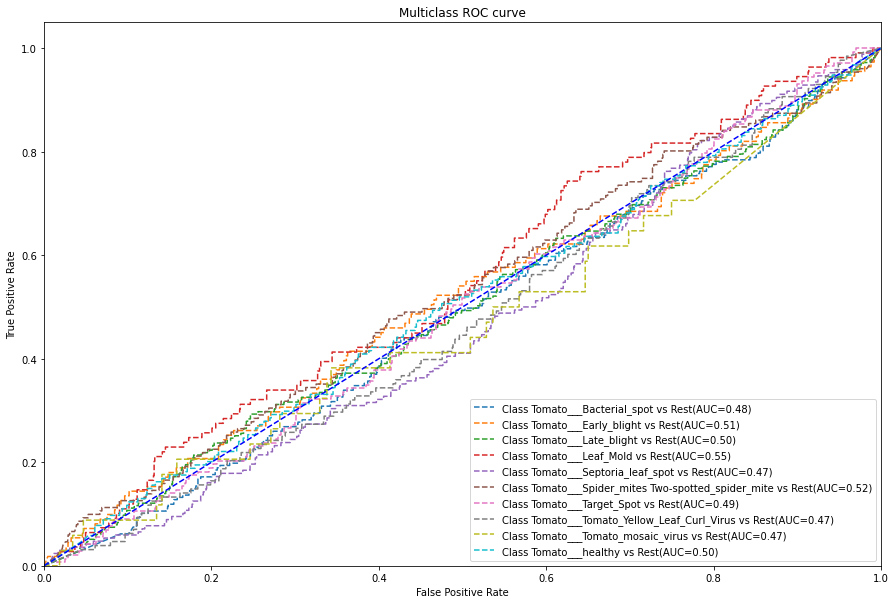

In [54]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresh=dict()
roc_auc = dict()

plt.figure(figsize=(15,10))
for i in range(10):
    fpr[i], tpr[i], thresh[i] = roc_curve(correct_labels, predict_probability[:, i],pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], linestyle='--',label='Class %s vs Rest(AUC=%0.2f)'%(target_names[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()